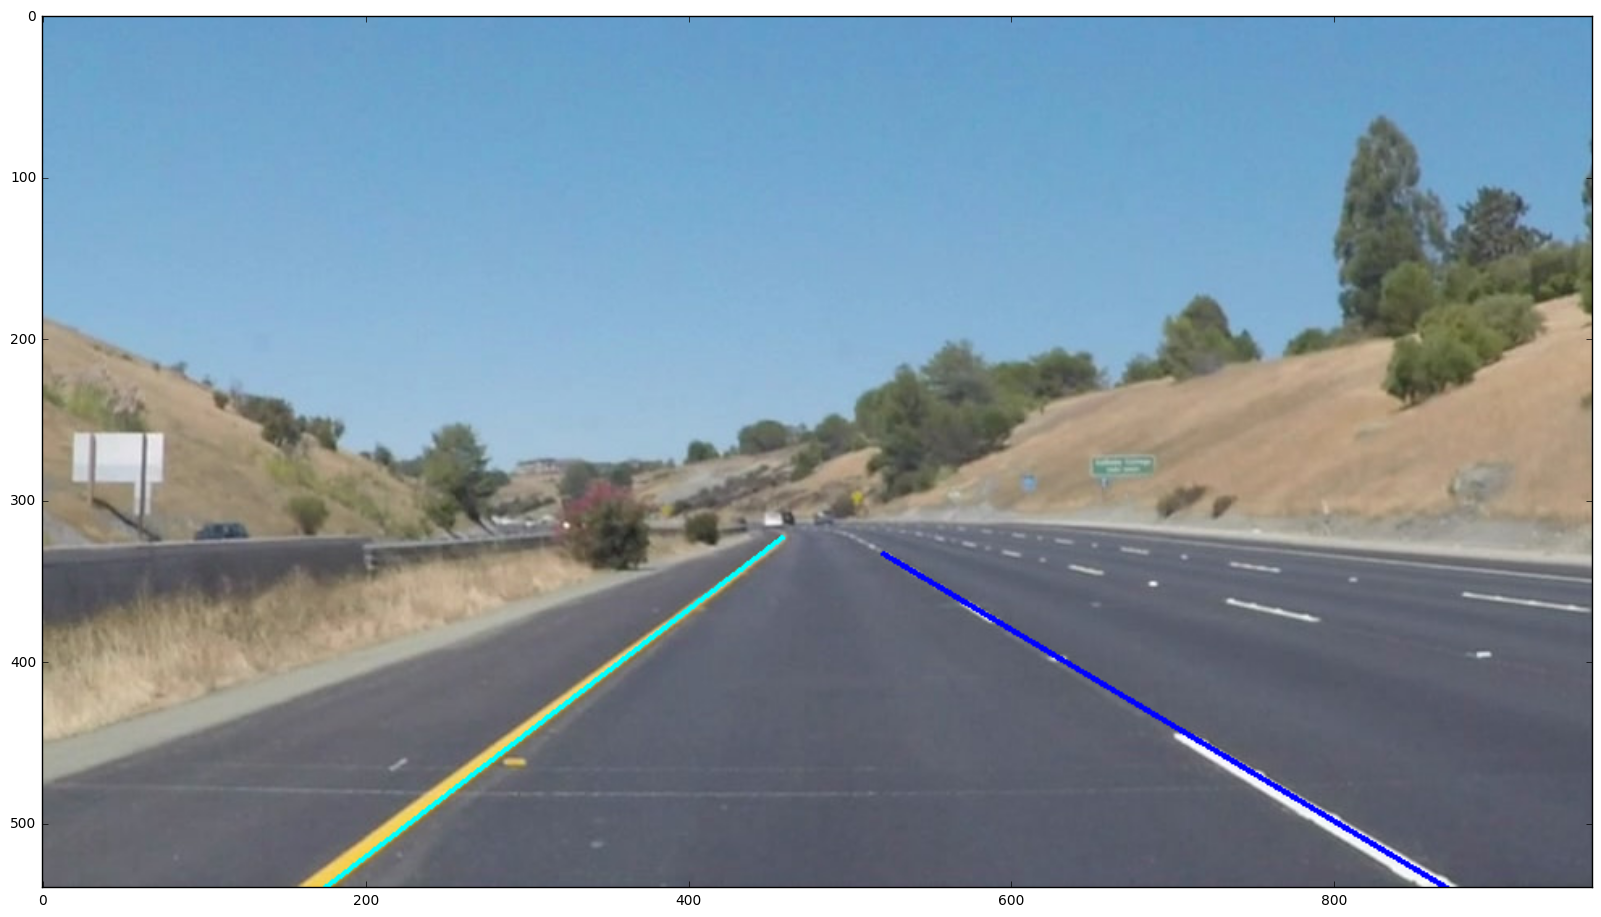

In [17]:
%matplotlib inline
import pylab
import matplotlib.pyplot as plt
import cv2
import numpy as np
import imageio
from itertools import izip


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def find_lines(image):
    
    bgr = []
    lines = []
    minLineLength = 10
    maxLineGap = 2
    kernel = np.ones((5,5))

    slope1 = []
    slope2 = []
    lines2 = []
    lines3 = []

    fit_x = []
    fit_y = []
    real_slope = 0
    real_intercept = 0

    fit_x2 = []
    fit_y2 = []
    real_slope2 = 0
    real_intercept2 = 0


    img = image

    colorbase = img.copy()
    colorbase2 = img.copy()
    bgr = img[...,::-1]

    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    blurred=cv2.GaussianBlur(gray,(7,7),0)
    canny=cv2.Canny(blurred, 50,150,3)
    vertices =np.array([[150,540],[460,310],[500,310],[960,540]], np.int32)
    masked = region_of_interest(canny, vertices)


    lines = cv2.HoughLinesP(masked, 1, np.pi/180, 25, minLineLength, maxLineGap)

    #print "all hough lines", lines
    for line in lines:
        for i,[x1,y1,x2,y2] in enumerate(line):
            temp_slope=((y2-y1)/float(x2-x1))

            if temp_slope >= 0.3:
                lines2.append([x1,y1,x2,y2])
                slope1.append(temp_slope)
            elif temp_slope <= -0.6:
                lines3.append([x1,y1,x2,y2])
                slope2.append(temp_slope)


    lines2 = np.expand_dims(np.array(lines2), axis=0)
    lines3 = np.expand_dims(np.array(lines3), axis=0)

    # sorting points
    lines2_srtd = sorted(lines2[0], key=lambda k:k[0])
    lines3_srtd = sorted(lines3[0], key=lambda k:k[0])
    #print "l2 sort", lines2_srtd
    #print "l3 sort", lines3_srtd
    lines2_srtd = np.expand_dims(np.array(lines2_srtd), axis=0)
    lines3_srtd = np.expand_dims(np.array(lines3_srtd), axis=0)

    for line in lines2_srtd:
        for x1,y1,x2,y2 in line:
            #print "oryg", x1,y1,x2,y2
            av_x = (x2+x1)/2
            #print "avg x",av_x
            av_y = (y2+y1)/2
            #print "avg y",av_y
            fit_x.append(av_x)
            fit_y.append(av_y)


    real_slope, real_intercept = np.polyfit(fit_x,fit_y,1)
    first_x = min(fit_x)
    #print first_x

    for line in lines3_srtd:
        for x1,y1,x2,y2 in line:
            #print "oryg", x1,y1,x2,y2
            av_x = (x2+x1)/2
            #print "avg x",av_x
            av_y = (y2+y1)/2
            #print "avg y",av_y
            fit_x2.append(av_x)
            fit_y2.append(av_y)


    real_slope2, real_intercept2 = np.polyfit(fit_x2,fit_y2,1)
    first_x2 = max(fit_x2)
    #print first_x2
    #print real_slope, real_intercept, first_x, real_slope2, real_intercept2, first_x2
    return real_slope, real_intercept, first_x, real_slope2, real_intercept2, first_x2

def draw_avg_lines(image, real_slope, real_intercept, first_x, real_slope2, real_intercept2, first_x2):
    end_x = 960
    end_x2 = 0
    
    first_y = int(real_slope * first_x + real_intercept)
    first_y2 = int(real_slope2 * first_x2 + real_intercept2)
    
    end_y = int(real_slope * end_x + real_intercept)
    end_y2 = int(real_slope2 * end_x2 + real_intercept2)
    
    cv2.line(image, (first_x, first_y), (end_x, end_y), (0,0,255), 2)
    cv2.line(image, (first_x2, first_y2), (end_x2, end_y2), (0,255,255), 2)

    return image

filename = '../CarND-LaneLines-P1/test_images/solidYellowCurve2.jpg'
image_for_processing = plt.imread(filename)

real_slope, real_intercept, first_x, real_slope2, real_intercept2, first_x2 = find_lines(image_for_processing)

processed_image = draw_avg_lines (image_for_processing, real_slope, real_intercept, first_x, real_slope2, real_intercept2, first_x2)

plt.figure(figsize=(20,20))
plt.imshow(processed_image)
plt.show()

# jesli lista (lub deque) dluzsza niz 10, usun pierwszy
# doloz nastepny (append), policz srednia - uzyj do rysowania

